# Problem Statement

The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.
Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.   
There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts.    
Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.

Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 

# Data Set Description

The data set contains the training set, which has approximately 1,59,000 samples and the test set which contains nearly 1,53,000 samples. All the data samples contain 8 fields which includes ‘Id’, ‘Comments’, ‘Malignant’, ‘Highly malignant’, ‘Rude’, ‘Threat’, ‘Abuse’ and ‘Loathe’. 
The label can be either 0 or 1, where 0 denotes a NO while 1 denotes a YES. There are various comments which have multiple labels. The first attribute is a unique ID associated with each comment.   
The data set includes:
-	Malignant: It is the Label column, which includes values 0 and 1, denoting if the comment is malignant or not. 
-	Highly Malignant: It denotes comments that are highly malignant and hurtful. 
-	Rude: It denotes comments that are very rude and offensive.
-	Threat: It contains indication of the comments that are giving any threat to someone. 	
-	Abuse: It is for comments that are abusive in nature. 
-	Loathe: It describes the comments which are hateful and loathing in nature.  
-	ID: It includes unique Ids associated with each comment text given.   
-	Comment text: This column contains the comments extracted from various social media platforms. 

This project is more about exploration, feature engineering and classification that can be done on this data. Since the data set is huge and includes many categories of comments, we can do good amount of data exploration and derive some interesting features using the comments text column available. 
You need to build a model that can differentiate between comments and its categories.  


In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None) # Display all the columns

In [2]:
df=pd.read_csv('malignant_train.csv')

In [3]:
# Let's have a look at top 5 rows
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Similarly, reading test dataset
df_test=pd.read_csv('malignant_test.csv')
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Multilabel vs Multiclass classification ?

In multi-class classification, the data can belong to only one label out of all the labels we have. For example, a given picture of a animal may be an cat, dog or elephant only and not a combination of these.

In multi-label classification, data can belong to more than one label simultaneously. For example, in our case a comment may be malignant, threat or loathe at the same time. It may also happen that the comment is positive/neutral and hence does not belong to any of the six labels.

This is therefore a multi-label classification problem.

In [5]:
df.shape

(159571, 8)

In [6]:
df_test.shape

(153164, 2)

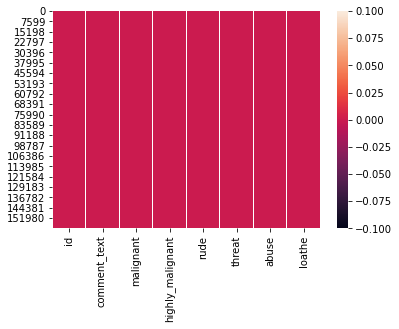

In [7]:
# Checking for null values
sns.heatmap(df.isnull())

In [8]:
df.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All values Range between 0 and 1, so there are no outliers or erroneous data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
# Let's have a look at the count plots of individual Categories.
categories=df.columns[2:]
categories

Index(['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'], dtype='object')

In [11]:
# Storing the number of counts for every target label
counts=df.iloc[:,2:].sum()
counts

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

In [12]:
# I want to know the percent of columns which are neither of the defined categories

none = df[(df['malignant']!=1) & (df['highly_malignant']!=1) & (df['rude']!=1) & 
                            (df['threat']!=1) & (df['abuse']!=1) & (df['loathe']!=1)]
percent=len(none)/len(df)*100
print('Percentage of good/neutral comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of good/neutral comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


In [13]:
# Adding new feature comment_length to store length of characters for train data
df['comment_length'] = df['comment_text'].apply(lambda x: len(str(x)))
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


In [14]:
# Adding new feature comment_length to store length of characters for test data
df_test['comment_length'] = df_test['comment_text'].apply(lambda x: len(str(x)))
df_test.head()

,id,comment_text,comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,00017563c3f7919a,":If you have a look back at the source, the in...",205
4,00017695ad8997eb,I don't anonymously edit articles at all.,41


# Data Vizualization

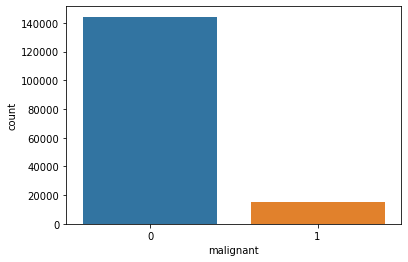

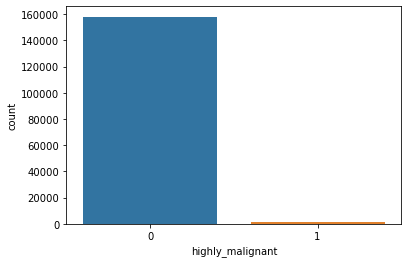

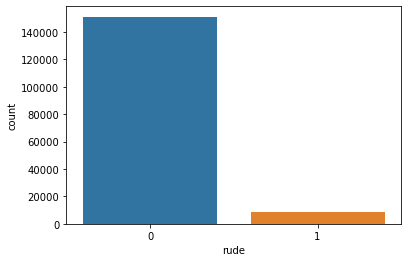

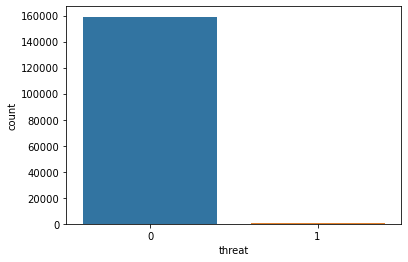

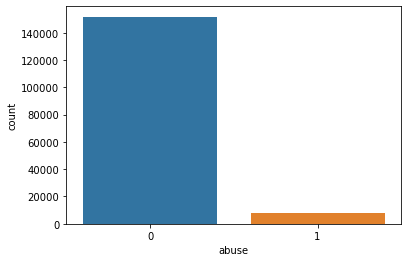

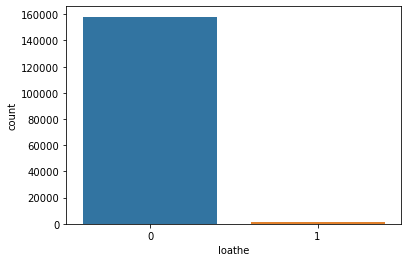

In [15]:
for col in categories:
    sns.countplot(df[col])
    plt.show()

While maximum Categories belong to Malignant, a lot of comments are abusive and rude as well; while threat comments are the minimum

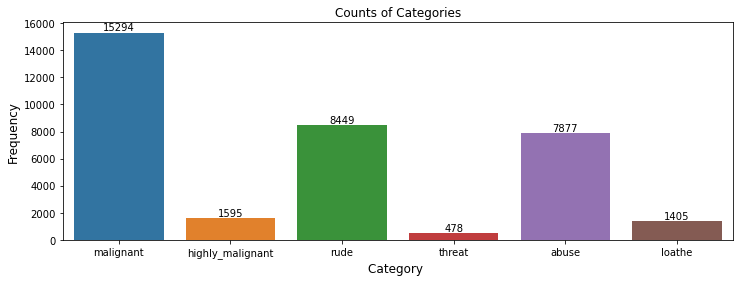

In [16]:
# Let's plot the counts of each category

plt.figure(figsize=(12,4))
ax = sns.barplot(counts.index, counts.values)
plt.title("Counts of Categories")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Category ', fontsize=12)
rects = ax.patches
labels = counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

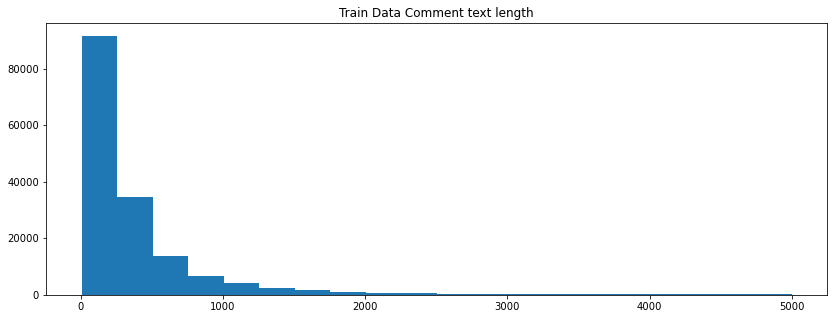

In [17]:
# plot for comments text counts for train data
plt.figure(figsize=(14,5))
plt.hist(df['comment_length'],bins=20)
plt.title("Train Data Comment text length")
plt.show()

In the train data, the maximum character lengths are between 0-250, then the frequency reduces as the number of characters increase

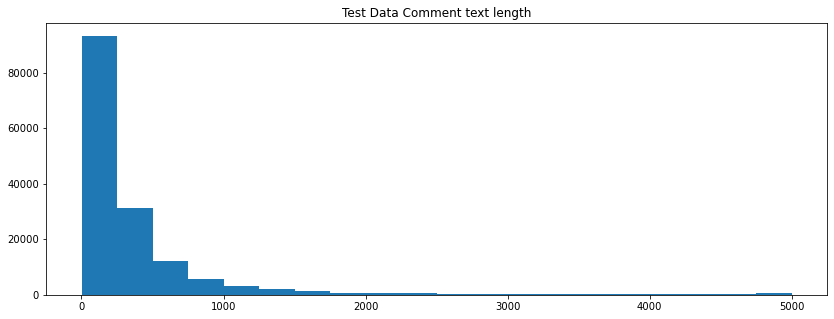

In [18]:
# plot for comments text counts for test data
plt.figure(figsize=(14,5))
plt.hist(df_test['comment_length'],bins=20)
plt.title("Test Data Comment text length")
plt.show()

Similar to the train data, here also the maximum character lengths are between 0-250, then the frequency reduces as the number of characters increase

# Data Preprocessing

In [19]:
df['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

The comments need to be modified before we can use them for modelling

In [20]:
# Fuction to remove short words
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [21]:
# function to filter using POS tagging. This will be called inside the below function
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning.
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [22]:
# Replacing short words with actual words in train and test data both
df['comment_text'] = df['comment_text'].map(lambda comments : clean_text(comments))
df_test['comment_text'] = df_test['comment_text'].map(lambda comments : clean_text(comments))

In [23]:
# cleaning the comments and storing them in a separate feature in train and test dataset both
df["clean_comment_text"] = df["comment_text"].apply(lambda x: Processed_data(x))
df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: Processed_data(x))

In [24]:
# Adding new feature clean_comment_length to store length of characters in train and test dataset both
df['clean_comment_length'] = df['clean_comment_text'].apply(lambda x: len(str(x)))
df_test['clean_comment_length'] = df_test['clean_comment_text'].apply(lambda x: len(str(x)))

In [25]:
#checking the train dataset after preprocessing
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,clean_comment_text,clean_comment_length
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,264,explanation edits username hardcore metallica ...,123
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,112,match background colour seemingly stuck thanks...,64
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,233,trying edit constantly removing relevant infor...,112
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,622,real suggestion improvement wondered section s...,315
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,67,hero chance remember page,25
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0,295,second time asking view completely contradicts...,157
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0,99,ashamed horrible thing talk page,32
159568,ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0,81,spitzer there actual article prostitution ring...,61
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0,116,look like actually speedy version deleted look,46


In [26]:
#checking the test dataset after preprocessing
df_test

,id,comment_text,comment_length,clean_comment_text,clean_comment_length
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,367,bitch rule succesful whats hating mofuckas bit...,184
1,0000247867823ef7,from rfc the title is fine as it is imo,50,title fine,10
2,00013b17ad220c46,sources zawe ashton on lapland,54,source zawe ashton lapland,26
3,00017563c3f7919a,if you have a look back at the source the info...,205,look source information updated correct form g...,104
4,00017695ad8997eb,i do not anonymously edit articles at all,41,anonymously edit article,24
...,...,...,...,...,...
153159,fffcd0960ee309b5,i totally agree this stuff is nothing but too ...,60,totally agree stuff long crap,29
153160,fffd7a9a6eb32c16,throw from out field to home plate does it get...,198,throw field home plate faster throwing direct ...,85
153161,fffda9e8d6fafa9e,okinotorishima categories i see your changes a...,423,okinotorishima category change agree correct g...,212
153162,fffe8f1340a79fc2,one of the founding nations of the eu germany ...,502,founding nation germany return similar israel ...,275


# Exploratory Data Analysis

In [27]:
from wordcloud import WordCloud

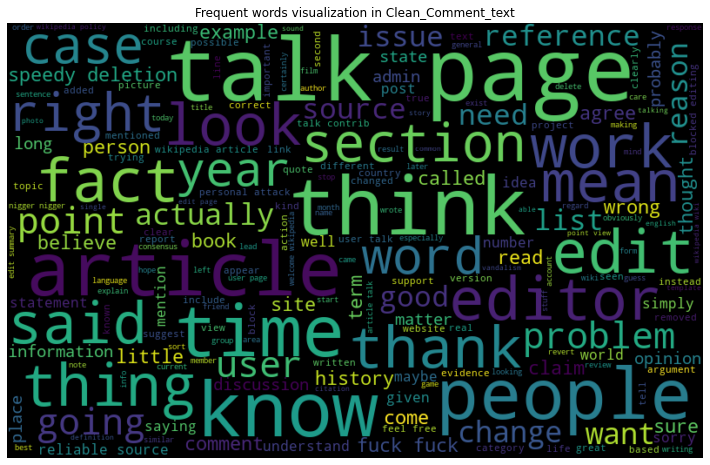

In [28]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_comment_text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization in Clean_Comment_text")
plt.axis('off')
plt.show()

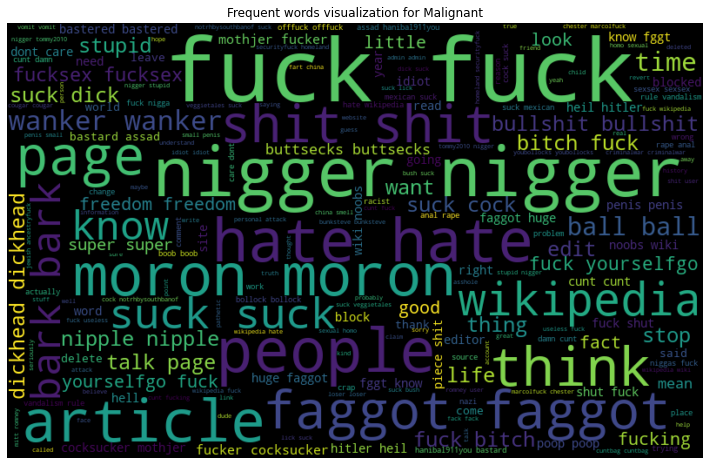

In [29]:
# frequent words visualization for malignant
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['malignant']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for Malignant")
plt.axis('off')
plt.show()

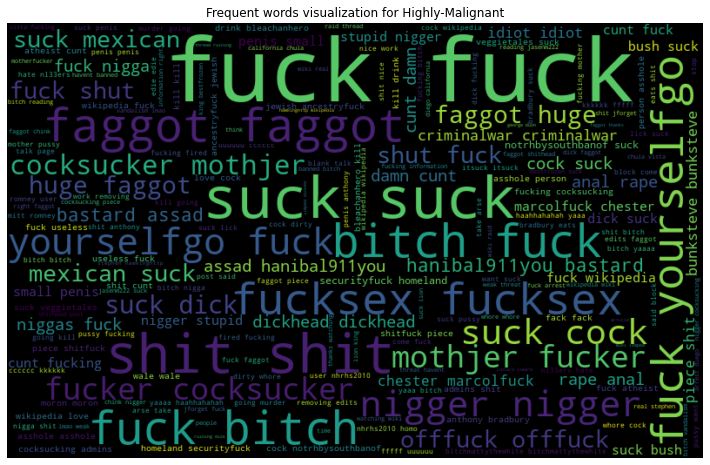

In [30]:
# frequent words visualization for highly_malignant
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['highly_malignant']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for Highly-Malignant")
plt.axis('off')
plt.show()

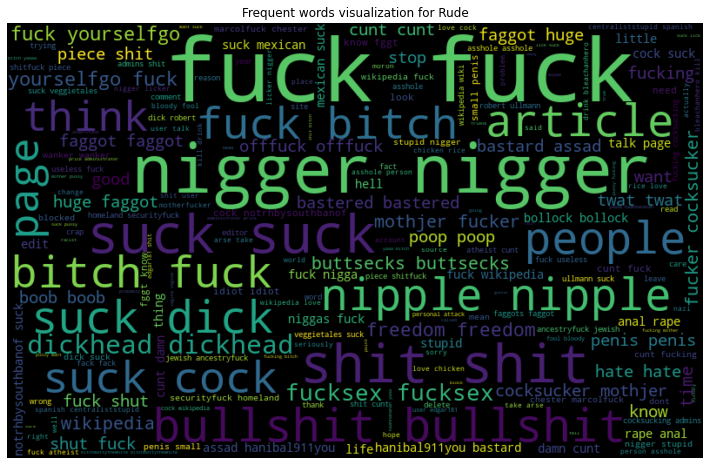

In [31]:
# frequent words visualization for rude
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['rude']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for Rude")
plt.axis('off')
plt.show()

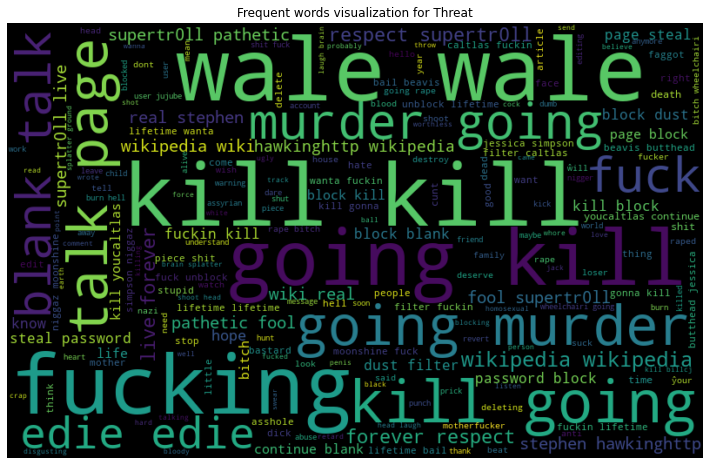

In [32]:
# frequent words visualization for Threat
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['threat']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for Threat")
plt.axis('off')
plt.show()

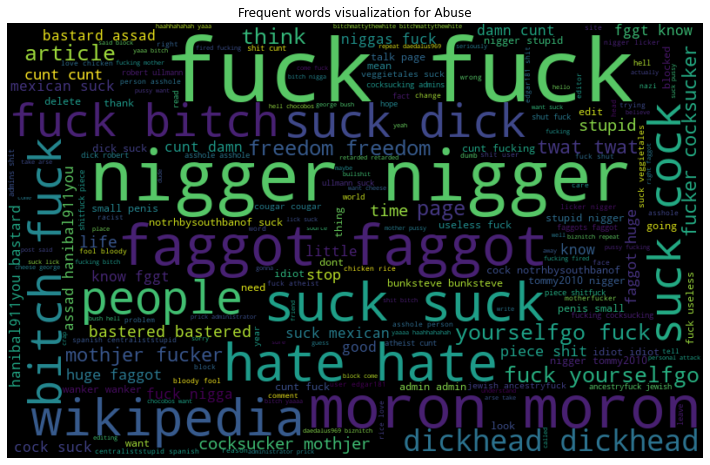

In [33]:
# frequent words visualization for abuse
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['abuse']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for Abuse")
plt.axis('off')
plt.show()

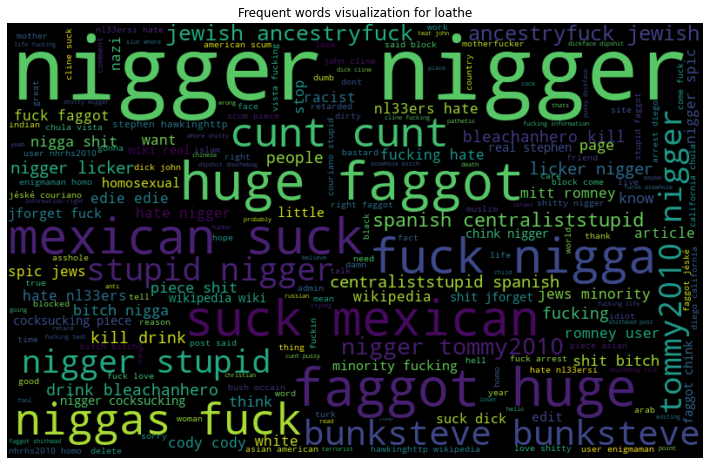

In [34]:
# frequent words visualization for loathe
all_words = " ".join([sentence for sentence in df['clean_comment_text'][df['loathe']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequent words visualization for loathe")
plt.axis('off')
plt.show()

# Creating Word dictionary

In [35]:
# Tokenizing
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [36]:
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(167609 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


# Feature Extraction

In [37]:
# TF-IDF(term frequency–inverse document frequency) vectorizer
def Tf_idf(text):
    tfid = TfidfVectorizer(min_df=2,smooth_idf=False)
    return tfid.fit_transform(text)

# Input Split

In [38]:
# Let's define x, y for modelling
x=Tf_idf(df['clean_comment_text'])
x.shape

(159571, 62791)

In [39]:
# For y
y = df.drop(columns=['id', 'comment_text', 'clean_comment_text','comment_length', 'clean_comment_length'])
y.shape

(159571, 6)

# Model Building

In [40]:
from sklearn.metrics import f1_score, accuracy_score, log_loss, recall_score, precision_score

# classify function
from sklearn.model_selection import cross_val_score, train_test_split
def classify(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    # train the model
    model.fit(x_train, y_train)
    print("Accuracy:", model.score(x_test, y_test))
    pred = model.predict(x_test)
    print("Log Loss:", log_loss(y_test, pred))
    print("Recall:", recall_score(y_test, pred, average='micro'))
    print("Precision:", precision_score(y_test, pred, average='micro'))
    
    # # cross-validation
    #score = cross_val_score(model, x, y, cv=5)
    #print("CV Score:", np.mean(score))

In [41]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
classify(model, x, y)

Accuracy: 0.8902710324298919
Log Loss: 1.2988274672416598
Recall: 0.5356234096692112
Precision: 0.6512547267102097


In [42]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
classify(model, x, y)

Accuracy: 0.8932476891743694
Log Loss: 1.1103358888739179
Recall: 0.4072660446706248
Precision: 0.7042287949156686


In [43]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
classify(model, x, y)

Accuracy: 0.913018956603478
Log Loss: 1.200646913283439
Recall: 0.5469324286118179
Precision: 0.8172792564427546


In [44]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
classify(model, x, y)

Accuracy: 0.9131442895190349
Log Loss: 1.207874679185791
Recall: 0.5357647724059937
Precision: 0.8239130434782609


# Hyperparameter Tuning - Using Randomized SearchCV

Random Forest is giving highest accuracy with highest precision

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [47]:
rfc=RandomForestClassifier()
parameters={'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500, 800, 1200]}

# Applying Randomized Search CV for hyperparameter tuning with scoring= "accuracy"
rand = RandomizedSearchCV(estimator = rfc, param_distributions = parameters, 
                          n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='accuracy')
rand.fit(x_train,y_train)
rand.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 52.0min finished


{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 100,
 'bootstrap': False}

# Best Model

Random Forest is giving highest accuracy with highest precision so we choose it as best model

In [48]:
RFC=RandomForestClassifier(n_estimators= 500,
                           min_samples_split= 2,
                           min_samples_leaf=1,
                           max_depth= 100,
                           bootstrap= False)

In [49]:
RFC.fit(x_train,y_train)
RFC.score(x_train,y_train)
pred=RFC.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,pred))
print('Log loss : ', log_loss(y_test,pred))
print("Recall:", recall_score(y_test, pred, average='micro'))
print("Precision:", precision_score(y_test, pred, average='micro'))

Accuracy Score: 0.9162462791790694
Log loss :  1.536268001619044
Recall: 0.5606446140797285
Precision: 0.844009363694403


# Cross Validation

In [50]:
# cross validation

from sklearn.model_selection import cross_val_score

scores=cross_val_score(RFC,x,y,cv=5)
print(scores)
print(scores.mean(),scores.std())

[0.91483628 0.91605565 0.91646299 0.91796704 0.9144576 ]
0.9159559137915405 0.001249815425296559


# Prediction on Test Data

In [54]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(min_df=2,max_features=62791,smooth_idf=False)
    return tfid.fit_transform(text)

In [55]:
x_testing_data=Tf_idf_test(df_test['clean_comment_text'])

In [56]:
x_testing_data.shape

(153164, 62791)

In [57]:
pred = RFC.predict(x_testing_data)

In [59]:
sub = pd.DataFrame(pred, columns=['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'])
sub['id'] = df_test['id']
sub = sub[['id', 'malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']]
sub.head()

,id,malignant,highly_malignant,rude,threat,abuse,loathe
0,00001cee341fdb12,0,0,0,0,0,0
1,0000247867823ef7,1,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [62]:
counts1=sub.iloc[:,1:].sum()
counts1

malignant           7073
highly_malignant      80
rude                2911
threat                16
abuse               1706
loathe               105
dtype: int64

In [63]:
sub.to_csv('submission.csv', index=False)